---

**IMPORTS**

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

---

# MATCHING USING SUM OF ABSOLUTE DIFFERENCE

In [ ]:
def SAD(Il, Ir,window_size,max_disparity):
    h, w= Il.shape

    disparity_map= np.zeros_like(Il, dtype=np.float32)

    half_window= window_size // 2

    for y in range(half_window, h - half_window):
        for x in range(half_window, w - half_window):

            best_cost = float('inf')
            best_disparity = 0

            for d in range(max_disparity):
                if x - d - half_window < 0: # momkn el window tkoon out f bounds mn el soora
                    continue

                left_win= Il[y - half_window:y + half_window + 1, x - half_window:x + half_window + 1]
                right_win= Ir[y - half_window:y + half_window + 1, x - d - half_window:x - d + half_window + 1] # btt7rk 4maal bs

                cost = np.sum(np.abs(left_win - right_win))

                if cost < best_cost:
                    best_cost = cost
                    best_disparity = d

            disparity_map[y, x] = best_disparity # carry Z coordinate of each pixel

    return disparity_map

---

# SAD WITH MAX DISPAIRTY=32

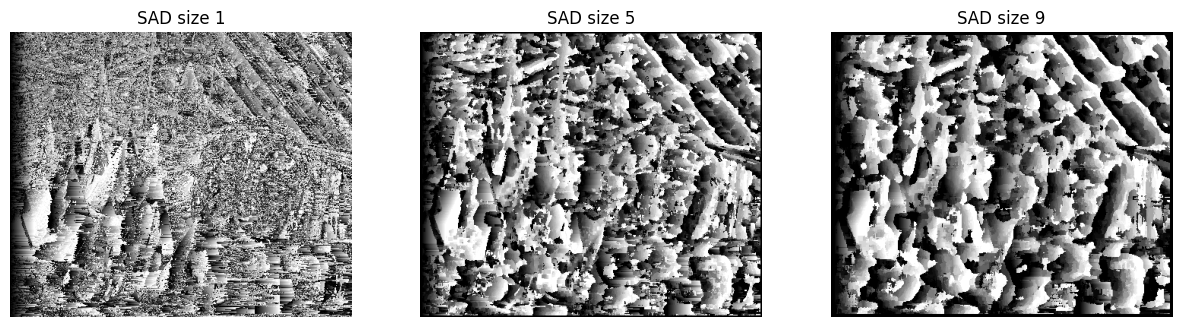

In [ ]:
left= cv2.imread('/content/l2.png', cv2.IMREAD_GRAYSCALE)
right= cv2.imread('/content/r2.png', cv2.IMREAD_GRAYSCALE)
window_sizes= [1, 5, 9]
fig, axis=plt.subplots(1, 3, figsize=(15, 5))

for idx,i in enumerate(window_sizes):
  sad= SAD(left, right, i,32)
  axis[idx].imshow(sad, cmap='gray')
  axis[idx].set_title(f'SAD size {i}')
  axis[idx].axis('off')

plt.show()

# SAD WITH MAX DISPARITY 64

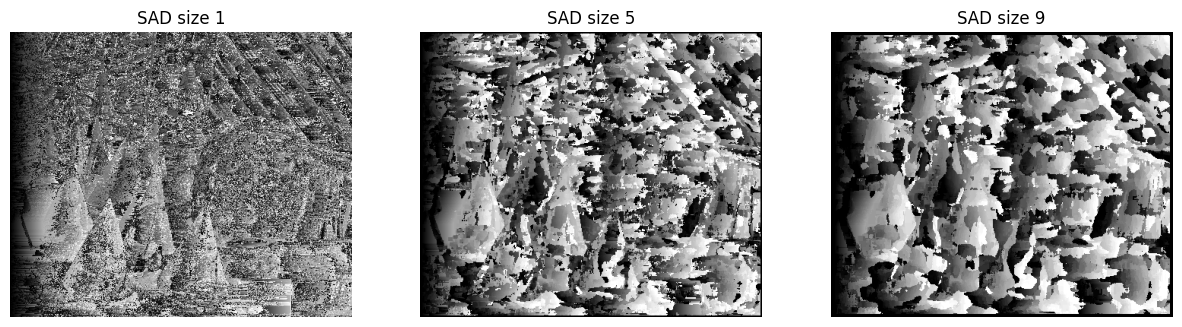

In [ ]:
left= cv2.imread('/content/l2.png', cv2.IMREAD_GRAYSCALE)
right= cv2.imread('/content/r2.png', cv2.IMREAD_GRAYSCALE)
window_sizes= [1, 5, 9]
fig, axis=plt.subplots(1, 3, figsize=(15, 5))
for idx,i in enumerate(window_sizes):
  sad= SAD(left, right, i,64)
  axis[idx].imshow(sad, cmap='gray')
  axis[idx].set_title(f'SAD size {i}')
  axis[idx].axis('off')

plt.show()

---

# **SSD CODE**

In [ ]:
def SSD(Il, Ir,window_size , max_disparity):
    h, w= Il.shape
    # max_disparity= 64
    disparity_map= np.zeros_like(Il, dtype=np.float32)
    half_w= window_size // 2

    for y in range(half_w, h - half_w):
        for x in range(half_w, w - half_w):
            best_cost = float('inf')
            best_disparity = 0

            for d in range(max_disparity):
                if x - d - half_w < 0:
                    continue

                window_l= Il[y - half_w:y + half_w + 1, x - half_w:x + half_w + 1]
                window_r= Ir[y - half_w:y + half_w + 1, x - d - half_w:x - d + half_w + 1]

                cost= np.sum((window_l - window_r)**2)

                if cost < best_cost:
                    best_cost= cost
                    best_disparity= d

            disparity_map[y,x]= best_disparity

    return disparity_map

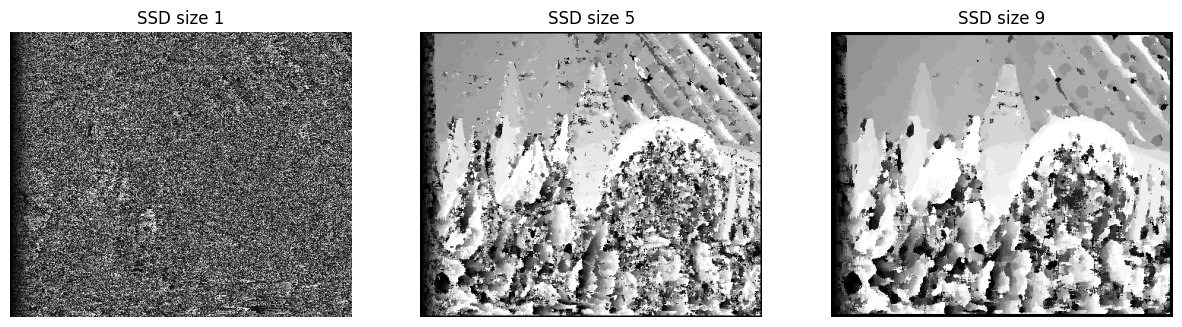

In [ ]:
left= cv2.imread('/content/l2.png', cv2.IMREAD_GRAYSCALE)
right= cv2.imread('/content/r2.png', cv2.IMREAD_GRAYSCALE)
window_sizes= [1, 5, 9]
fig, axis=plt.subplots(1, 3, figsize=(15, 5))

for idx,i in enumerate(window_sizes):
  sad= SSD(left, right, i , 32)
  axis[idx].imshow(sad, cmap='gray')
  axis[idx].set_title(f'SSD size {i}')
  axis[idx].axis('off')

plt.show()

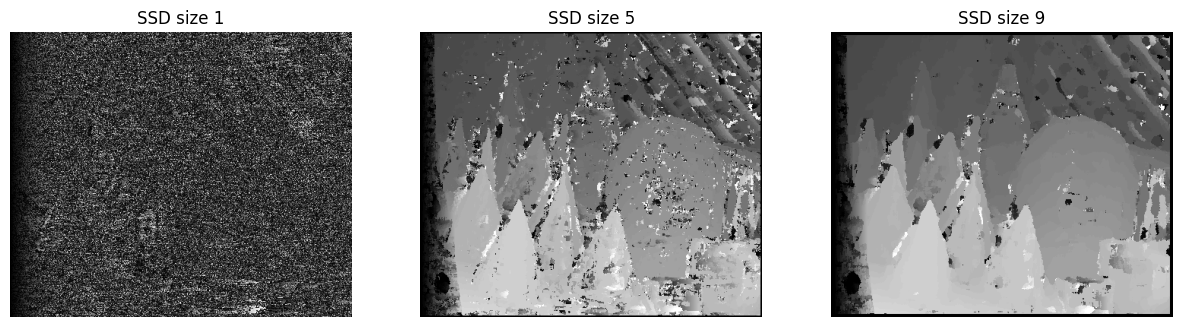

In [ ]:
left= cv2.imread('/content/l2.png', cv2.IMREAD_GRAYSCALE)
right= cv2.imread('/content/r2.png', cv2.IMREAD_GRAYSCALE)
window_sizes= [1, 5, 9]
fig, axis=plt.subplots(1, 3, figsize=(15, 5))

for idx,i in enumerate(window_sizes):
  sad= SSD(left, right, i , 64)
  axis[idx].imshow(sad, cmap='gray')
  axis[idx].set_title(f'SSD size {i}')
  axis[idx].axis('off')

plt.show()

---

# **DYNAMIC PROGRAMMING**

In [ ]:
def compute_disparity_dynamic_programming(Il, Ir, sigma=2, c0=1):
    # THis is bottom Up Approach
    assert Il.shape == Ir.shape, "Left and right images must have the same dimensions"
    Il = Il.astype(np.float32)
    Ir = Ir.astype(np.float32)
    h, w= Il.shape

    disparity_map = np.zeros_like(Il, dtype=np.float32)

    for row in range(h):
        #Extracting the scanlines from the current row
        left_scanline = Il[row]
        right_scanline = Ir[row]

        D = np.zeros((w, w), dtype=np.float32)
        D[0, 0] = (left_scanline[0] - right_scanline[0])**2 / sigma**2 # mfee4 diagonal hna

        #Fill the first row and column with skipping costs
        for i in range(1, w):
            D[i, 0] = D[i - 1, 0] + c0
            D[0, i] = D[0, i - 1] + c0

        #Fill the rest of the cost matrix
        for i in range(1, w):
            for j in range(1, w):
                match_cost = D[i - 1, j - 1] + ((left_scanline[i] - right_scanline[j])**2 / sigma**2)
                skip_left_cost = D[i - 1, j] + c0
                skip_right_cost = D[i, j - 1] + c0
                D[i, j] = min(match_cost, skip_left_cost, skip_right_cost)

        #Backtrack to find the optimal alignment
        i, j = w- 1, w- 1
        while i > 0 and j > 0:
            if i > 0 and j > 0 and D[i, j] == D[i - 1, j - 1] + ((left_scanline[i] - right_scanline[j])**2 / sigma**2):
                # Match: set disparity
                disparity_map[row, i] = abs(i - j)
                i -= 1
                j -= 1
            elif i > 0 and D[i, j] == D[i - 1, j] + c0:
                i -= 1 # Skip left
            else:
                j -= 1 # Skip right

    return disparity_map, D


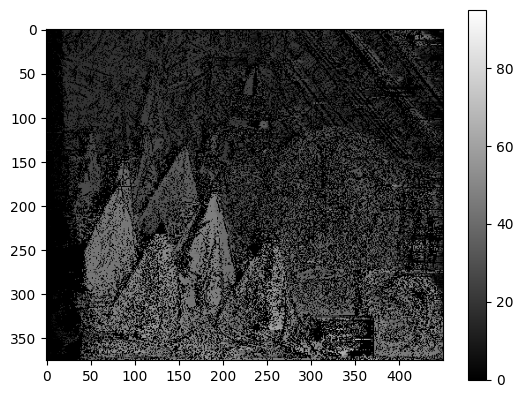

In [ ]:
left= cv2.imread('/content/l2.png', cv2.IMREAD_GRAYSCALE)
right= cv2.imread('/content/r2.png', cv2.IMREAD_GRAYSCALE)
dp,D= compute_disparity_dynamic_programming(left, right)
plt.imshow(dp, cmap='gray')
plt.colorbar()
plt.show()

---

# **BONUS PART**

In [ ]:
def visualize_scanline_alignment(Il, Ir, D, title='Scanline Alignment'):
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.xlabel('Right Image Pixel Index')
    plt.ylabel('Left Image Pixel Index')

    left_idx, right_idx = len(Il) - 1, len(Ir) - 1
    plt.plot(right_idx, left_idx, 'ro', label='Start (Bottom-Right)')

    while left_idx > 0 or right_idx > 0:
        current_cost = D[left_idx, right_idx]

        diag_cost = D[left_idx - 1, right_idx - 1] + ((Il[left_idx] - Ir[right_idx])**2) / (2**2) if left_idx > 0 and right_idx > 0 else float('inf')
        up_cost = D[left_idx - 1, right_idx] + 1 if left_idx > 0 else float('inf')
        left_cost = D[left_idx, right_idx - 1] + 1 if right_idx > 0 else float('inf')

        if left_idx > 0 and right_idx > 0 and current_cost == diag_cost:
            plt.plot([right_idx, right_idx - 1], [left_idx, left_idx - 1], 'g-', label='Match' if 'Match' not in plt.gca().get_legend_handles_labels()[1] else "")
            left_idx -= 1
            right_idx -= 1
        elif left_idx > 0 and current_cost == up_cost:
            # Skip in left image: move up
            plt.plot([right_idx, right_idx], [left_idx, left_idx - 1], 'b-', label='Left Skip' if 'Left Skip' not in plt.gca().get_legend_handles_labels()[1] else "")
            left_idx -= 1
        else:
            # Skip in right image: move left
            plt.plot([right_idx, right_idx - 1], [left_idx, left_idx], 'r-', label='Right Skip' if 'Right Skip' not in plt.gca().get_legend_handles_labels()[1] else "")
            right_idx -= 1

    plt.legend()
    plt.grid(True)
    plt.show()

<ipython-input-16-d607a6bfdc45>:13: RuntimeWarning: overflow encountered in scalar subtract
  diag_cost = D[left_idx - 1, right_idx - 1] + ((Il[left_idx] - Ir[right_idx])**2) / (2**2) if left_idx > 0 and right_idx > 0 else float('inf')


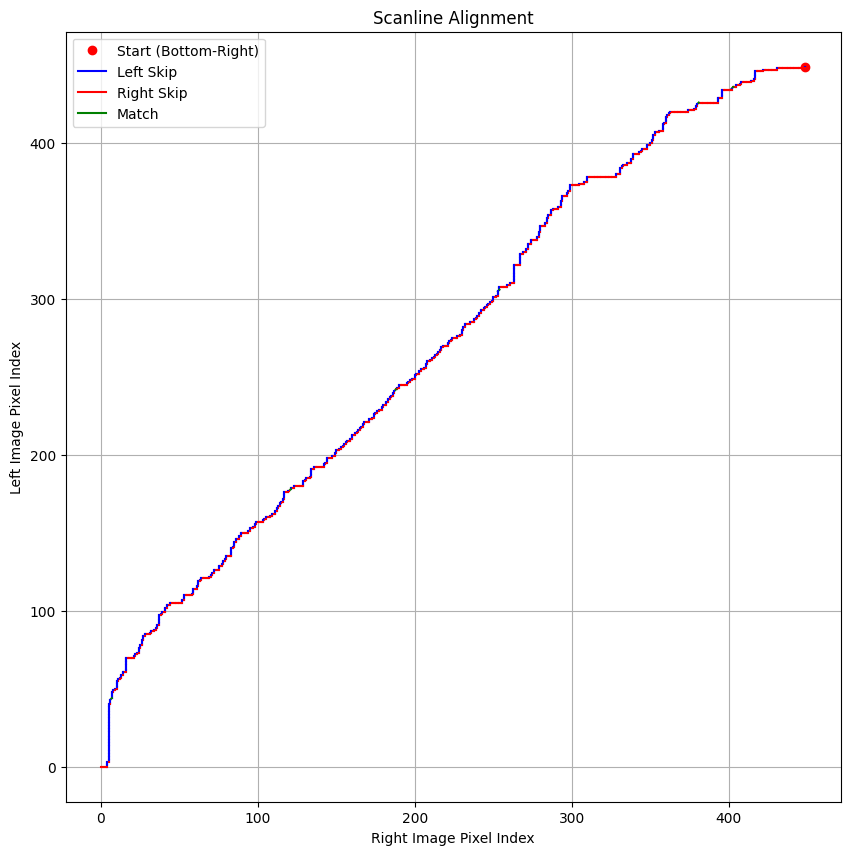

In [ ]:
height, width= left.shape[:2]
middle_row= height // 2
left_scanline= left[middle_row, :]
right_scanline= right[middle_row, :]
visualize_scanline_alignment(left_scanline, right_scanline, D)

---